# Predicting Star Ratings from Text Comments and Reviews

### By Shefali Saxena
### NetID: shefali5

Note: I ran this notebook on Kernel conda_pytorch_310 in AWS Sagemaker which ran without any issues in order to train BERT


In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install --upgrade transformers


  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.26.5-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.4.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached transformers-4.47.0-py3-none-any.whl (10.1 MB)
Using cached huggingface_hub-0.26.5-py3-none-any.whl (447 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 35.7 MB/s eta 0:00:00
Using cached safetensors-0.4.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)


In [3]:
!pip install nltk wordcloud


  Using cached wordcloud-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.2 MB/s eta 0:00:00
Using cached wordcloud-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511 kB)


In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
import string
import warnings

# Suppress Warnings
warnings.filterwarnings("ignore")

# Download NLTK Data
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# !nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [5]:
import pandas as pd

# Load Data
df = pd.read_csv("amazon_reviews.csv")
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [6]:
df.describe()

,score,thumbsUpCount
count,6116.000000,6116.000000
mean,2.513244,11.981524
std,1.689365,64.983828
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,2.000000
max,5.000000,1565.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              6116 non-null   object
 1   userName              6115 non-null   object
 2   content               6116 non-null   object
 3   score                 6116 non-null   int64 
 4   thumbsUpCount         6116 non-null   int64 
 5   reviewCreatedVersion  5486 non-null   object
 6   at                    6116 non-null   object
 7   appVersion            5486 non-null   object
dtypes: int64(2), object(6)
memory usage: 382.4+ KB


In [8]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,67bb1b5a-85ac-4a12-9c26-0ac8fe7da2e7,Corey Allen,Literally every order tries to get you to pay ...,1,0,24.5.2.100,2022-03-19 05:18:51,24.5.2.100
1,fda071c5-6b3e-4bec-be33-6dcc626c3342,Unlock_ur _mind,The past 2x I have ordered from Amazon Prime I...,1,4,22.4.0.100,2021-02-20 22:12:39,22.4.0.100
2,12a5f5d3-6ca4-43b4-9a98-a6d46fb44e4c,Cathy RH,I love this app I use almost every time I orde...,5,6,24.17.0.100,2022-09-21 15:52:11,24.17.0.100
3,99cb4365-0ec2-41e8-95e4-a581d5e36d42,Leon Phelps,Beware!!! Beware!!! I bought an item I thought...,1,0,20.22.2.100,2020-11-19 00:14:01,20.22.2.100
4,04c90f96-4494-4135-8da2-6d7595161b4c,matt norton,Update sucks. Please fix and by fix I mean go ...,1,0,22.7.0.100,2021-04-07 14:11:27,22.7.0.100


In [9]:
df["content"] = df["content"].fillna("")
df["reviewCreatedVersion"] = df["reviewCreatedVersion"].fillna("Unknown")
df["appVersion"] = df["appVersion"].fillna("Unknown")

# Preserve Original Scores for Visualization
original_scores = df["score"]

# Label Encoding for Model Training
encoder = LabelEncoder()
df["encoded_score"] = encoder.fit_transform(df["score"])  # Encode scores to 0-4
df["score"] = original_scores  # Preserve original 1-5 star ratings for visualization

# Preprocessing
stop_words = set(nltk.corpus.stopwords.words("english"))


def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text


df["cleaned_content"] = df["content"].apply(preprocess_text)

Performing Exploratory Data Analysis...


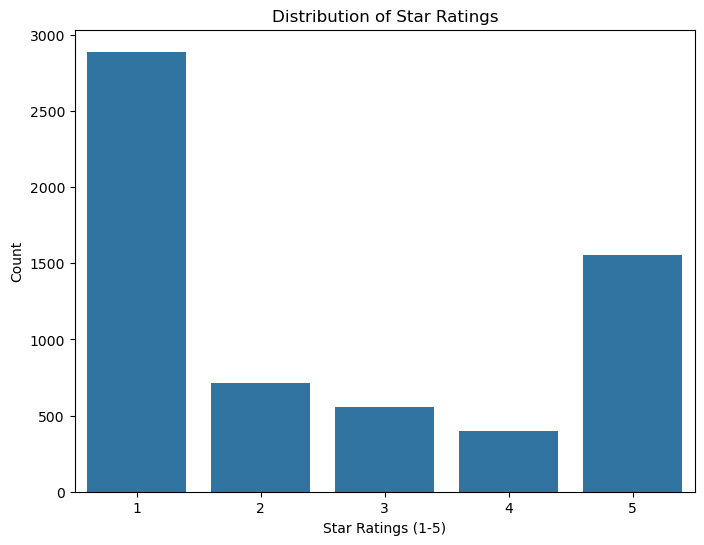

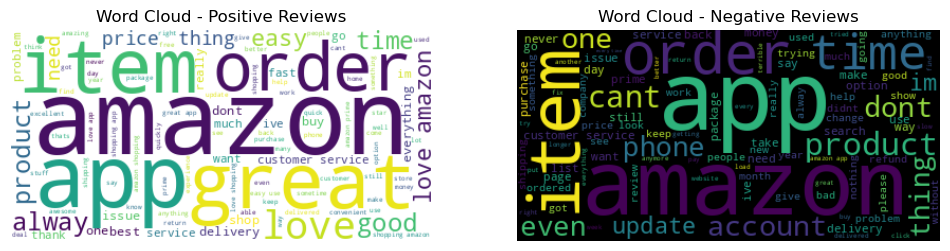

In [10]:
# EDA
print("Performing Exploratory Data Analysis...")

# Distribution of Star Ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="score", order=sorted(df["score"].unique()))
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Ratings (1-5)")
plt.ylabel("Count")
plt.show()

# Word Clouds for Positive and Negative Reviews
positive_text = " ".join(df[df["score"] > 3]["cleaned_content"])
negative_text = " ".join(df[df["score"] <= 3]["cleaned_content"])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color="white", max_words=100).generate(positive_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")

plt.subplot(1, 2, 2)
wordcloud = WordCloud(background_color="black", max_words=100).generate(negative_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()


In [ ]:
# TF-IDF Feature Engineering for Traditional Models
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["cleaned_content"]).toarray()
y = df["encoded_score"]  # Use encoded scores (0-4) for model training

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Traditional Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVC": SVC(),
    "Random Forest": RandomForestClassifier(),
}

# Hyperparameter Tuning for SVC
svc_pipeline = Pipeline([
    ("classifier", SVC())
])
svc_param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"],
}
svc_grid = GridSearchCV(svc_pipeline, svc_param_grid, cv=3)
svc_grid.fit(X_train, y_train)

# Evaluating Traditional Models
print("\nEvaluating Traditional Models...")
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    results.append((name, accuracy, f1))
    print(f"\n{name} Performance:")
    print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred)))

# Add SVC GridSearchCV Results
svc_tuned_f1 = f1_score(y_test, svc_grid.best_estimator_.predict(X_test), average="macro")
results.append(("SVC (Tuned)", svc_grid.best_score_, svc_tuned_f1))

# Model Performance Summary
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1-Score"])
print("\nModel Performance Summary:")
print(results_df)



Evaluating Traditional Models...

Logistic Regression Performance:
              precision    recall  f1-score   support

           1       0.64      0.97      0.77       578
           2       0.23      0.02      0.04       143
           3       0.21      0.03      0.05       111
           4       0.00      0.00      0.00        80
           5       0.80      0.80      0.80       312

    accuracy                           0.67      1224
   macro avg       0.38      0.36      0.33      1224
weighted avg       0.55      0.67      0.58      1224



In [ ]:
# Confusion Matrix for the Best Model
best_model_name = results_df.sort_values(by="Macro F1-Score", ascending=False).iloc[0]["Model"]
best_model = svc_grid.best_estimator_ if best_model_name == "SVC (Tuned)" else models[best_model_name]
y_pred_best = best_model.predict(X_test)
y_pred_best_original = encoder.inverse_transform(y_pred_best)
y_test_original = encoder.inverse_transform(y_test)

conf_matrix = confusion_matrix(y_test_original, y_pred_best_original)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted Star Ratings")
plt.ylabel("Actual Star Ratings")
plt.show()

In [ ]:
# BERT for Sequence Classification
print("\nTraining BERT Model...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


class ReviewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

X_train_indices, X_test_indices = train_test_split(df.index, test_size=0.2, random_state=42, stratify=df["encoded_score"])

train_dataset = ReviewsDataset(df.loc[X_train_indices, "cleaned_content"], y_train)
test_dataset = ReviewsDataset(df.loc[X_test_indices, "cleaned_content"], y_test)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(y.unique()))

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Performing Exploratory Data Analysis...


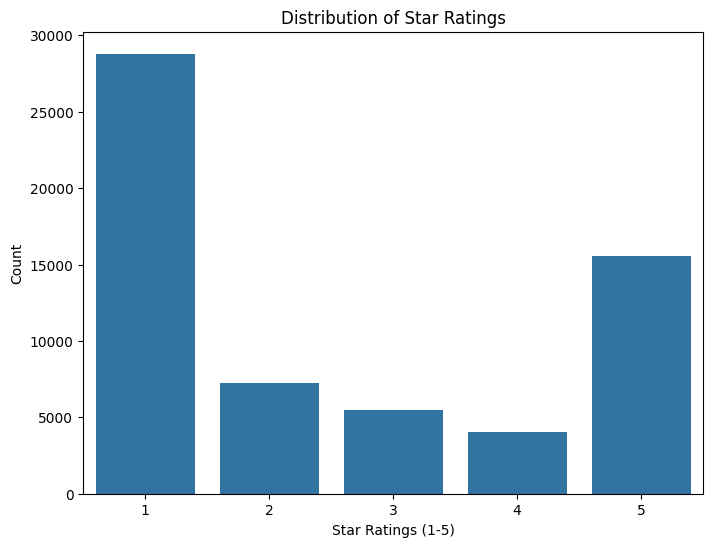

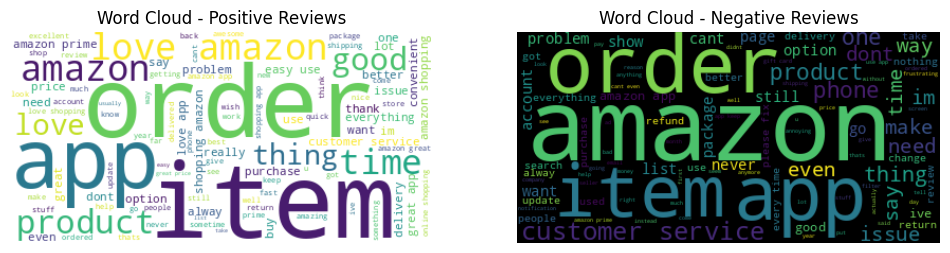


Evaluating Traditional Models...

Logistic Regression Performance:
              precision    recall  f1-score   support

           1       0.69      0.93      0.79      5760
           2       0.29      0.07      0.12      1449
           3       0.30      0.09      0.14      1099
           4       0.37      0.11      0.17       813
           5       0.80      0.88      0.83      3111

    accuracy                           0.69     12232
   macro avg       0.49      0.42      0.41     12232
weighted avg       0.61      0.69      0.62     12232




Evaluating BERT Model...



Classification Report for BERT:
              precision    recall  f1-score   support

           1       0.72      0.86      0.79       578
           2       0.33      0.15      0.20       143
           3       0.24      0.18      0.21       111
           4       0.46      0.24      0.31        80
           5       0.81      0.90      0.85       312

    accuracy                           0.69      1224
   macro avg       0.51      0.47      0.47      1224
weighted avg       0.64      0.69      0.65      1224



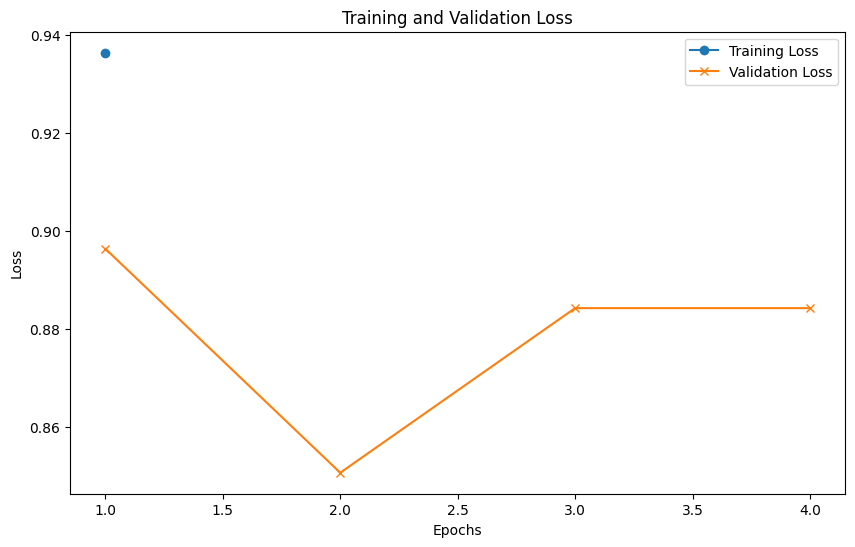

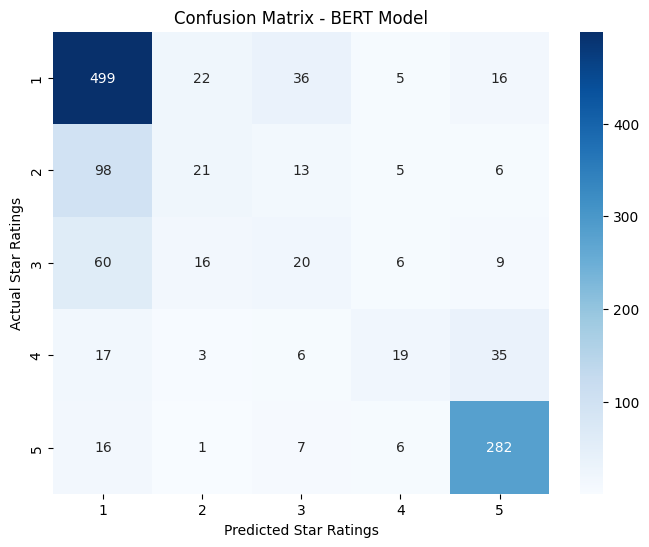

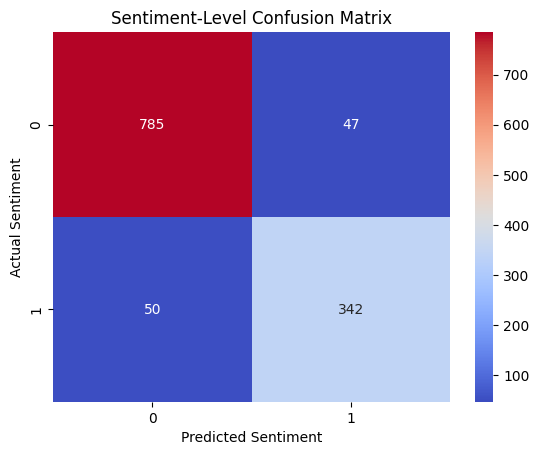

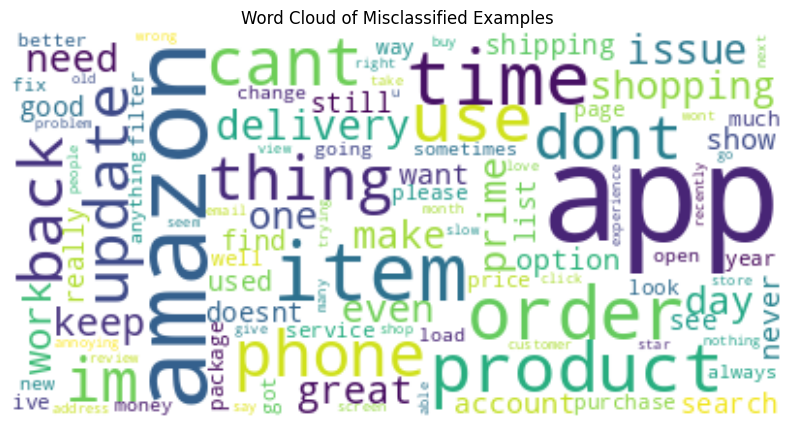


BERT results saved successfully.


In [ ]:
# Evaluate BERT Model
print("\nEvaluating BERT Model...")
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Classification Report
# Classification Report for BERT
print("\nClassification Report for BERT:")
target_names = [str(cls) for cls in encoder.classes_]  # Convert classes to strings
print(classification_report(y_test, pred_labels, target_names=target_names))

# Loss and Accuracy Curves for BERT
# Loss and Accuracy Curves for BERT
training_logs = trainer.state.log_history
loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Use the correct range for epochs
epochs_loss = range(1, len(loss) + 1)
epochs_eval = range(1, len(eval_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_loss, loss, label="Training Loss", marker='o')
plt.plot(epochs_eval, eval_loss, label="Validation Loss", marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Confusion Matrix for BERT
conf_matrix_bert = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bert, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title("Confusion Matrix - BERT Model")
plt.xlabel("Predicted Star Ratings")
plt.ylabel("Actual Star Ratings")
plt.show()

# Sentiment-Level Confusion Matrix
y_test_sentiment = (y_test > 2).astype(int)  # Positive = 1, Negative = 0
pred_sentiment = (pred_labels > 2).astype(int)
conf_matrix_sentiment = confusion_matrix(y_test_sentiment, pred_sentiment)

sns.heatmap(conf_matrix_sentiment, annot=True, fmt="d", cmap="coolwarm")
plt.title("Sentiment-Level Confusion Matrix")
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")
plt.show()

# Word Cloud of Misclassified Examples
misclassified_text = " ".join(df.loc[X_test_indices][y_test != pred_labels]["cleaned_content"])
wordcloud = WordCloud(background_color="white", max_words=100).generate(misclassified_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Misclassified Examples")
plt.show()

# Save BERT Results
np.save("confusion_matrix_bert.npy", conf_matrix_bert)
trainer.save_model("./bert_trained_model")
print("\nBERT results saved successfully.")
